# PROJET PHASE 2 - Notebook Modele Energie (V2)

## Version corrigee pour evaluation rigoureuse


In [1]:
!pip install matplotlib seaborn numpy scikit-learn pandas

'pip' nâ€™est pas reconnu en tant que commande interne
ou externe, un programme exÃ©cutable ou un fichier de commandes.


In [2]:
!pip install scikit-learn xgboost


'pip' nâ€™est pas reconnu en tant que commande interne
ou externe, un programme exÃ©cutable ou un fichier de commandes.


In [3]:
# 1. Manipulation des données et système
import os
import sys
import pandas as pd
import numpy as np


# 2. Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Préparation des données (Preprocessing)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 4. Modèles (Algorithmes)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 5. Évaluation et Sauvegarde
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# ETAPE 7.0 - Chargement du pack de données pour la modélisation énergie


In [4]:
data_pack = joblib.load("model_data_phase2_v2.joblib")

In [5]:
X_fe = data_pack["X_fe"]
y_energy = data_pack["y_energy"]
y_co2 = data_pack["y_co2"]
num_cols = data_pack["num_cols"]
cat_cols = data_pack["cat_cols"]

In [6]:
print("X_fe shape:", X_fe.shape)
print("y_energy shape:", y_energy.shape, "| y_co2 shape:", y_co2.shape)
print("Nb num_cols:", len(num_cols), "| Nb cat_cols:", len(cat_cols))

X_fe shape: (3348, 22)
y_energy shape: (3348,) | y_co2 shape: (3348,)
Nb num_cols: 15 | Nb cat_cols: 6


À cette étape, nous rechargeons le jeu de données final issu du feature engineering réalisé dans le notebook 1, afin d’éviter toute reconstruction inutile et tout risque d’incohérence entre les notebooks. Le jeu de features X_fe contient 3348 observations et 22 variables explicatives, tandis que les deux cibles y_energy (consommation d’énergie) et y_co2 (émissions de CO₂) contiennent également 3348 valeurs, ce qui garantit un alignement parfait entre features et cibles. Les variables explicatives sont réparties en 15 variables numériques et 6 variables catégorielles, configuration qui sera utilisée pour construire le pipeline de prétraitement (imputation, normalisation et encodage) de manière rigoureuse et sans fuite d’information. Cette étape permet de figer définitivement la base de travail pour la modélisation et d’assurer la reproductibilité et la traçabilité des résultats obtenus par la suite.

# ETAPE 7.1 - Split train / test pour le modèle énergie


In [7]:



X_train, X_test, y_train_energy, y_test_energy = train_test_split(
    X_fe,
    y_energy,
    test_size=0.2,
    random_state=42
)



In [8]:
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train_energy:", y_train_energy.shape, "| y_test_energy:", y_test_energy.shape)


X_train: (2678, 22) | X_test: (670, 22)
y_train_energy: (2678,) | y_test_energy: (670,)


Nous avons séparé le jeu de données en un ensemble d’entraînement et un ensemble de test afin d’évaluer la capacité de généralisation du modèle sur des bâtiments jamais vus pendant l’apprentissage. Le découpage 80/20 produit un X_train de (2678, 22) et un X_test de (670, 22), avec les cibles associées y_train_energy de (2678, ) et y_test_energy de (670, ), ce qui confirme l’alignement correct entre features et cible. Ce split est réalisé avant tout prétraitement pour éviter toute fuite d’information (imputation et normalisation apprises uniquement sur le train), et random_state=42 garantit la reproductibilité des résultats, condition essentielle pour comparer proprement plusieurs modèles et mesurer l’effet des choix de feature engineering sur le surapprentissage.

Le split train/test est globalement représentatif, mais il présente quelques déséquilibres modérés susceptibles d’augmenter l’écart Train/Test. Côté catégories, BuildingType montre une sur-représentation de NonResidential dans le test (≈ +6,5 points) et une sous-représentation de Multifamily LR (1-4) (≈ −4,1 points), ce qui peut rendre le test “plus difficile” si les non-résidentiels ont des consommations plus hétérogènes et plus extrêmes. PrimaryPropertyType est assez proche entre train et test, avec de petits écarts (ex. “Small- and Mid-Sized Office” et “Large Office” légèrement plus présents en test), ce qui reste acceptable. Côté numériques, les quantiles sont globalement cohérents (médianes proches), mais on observe des différences sur les très hauts quantiles (99e) pour NumberofFloors et surtout les surfaces (PropertyGFATotal, LargestPropertyUseTypeGFA), ce qui confirme que les extrêmes ne se répartissent pas parfaitement et peuvent fortement impacter le RMSE et l’impression de surapprentissage. En résumé, le split n’est pas “mauvais”, mais la combinaison (déséquilibre léger par type) + extrêmes peut suffire à créer un grand écart entre performance train et test.

# ETAPE 7.2a AUDIT - Taux de valeurs manquantes dans X_fe (v2)


In [9]:

missing_rate = X_fe.isna().mean().sort_values(ascending=False)
print(missing_rate[missing_rate > 0])


SecondLargestPropertyUseType    0.499104
ENERGYSTARScore                 0.244026
GFA_per_floor                   0.004779
LargestPropertyUseType          0.003286
LargestPropertyUseTypeGFA       0.003286
dtype: float64


L’audit des valeurs manquantes sur le jeu de features final montre que les manques ne sont pas uniformes : SecondLargestPropertyUseType est manquant dans environ 49,9 % des cas (absence très fréquente d’un second usage), ENERGYSTARScore dans environ 24,4 % des cas, tandis que les autres manques sont faibles (GFA_per_floor ≈ 0,48 %, LargestPropertyUseType et LargestPropertyUseTypeGFA ≈ 0,33 %). Cette structure indique que certains manques sont potentiellement informatifs (notamment l’absence de second usage) et qu’une stratégie d’imputation doit à la fois (i) éviter d’inventer une information inexistante et (ii) permettre au modèle de tirer parti du fait qu’une valeur est manquante.

# ETAPE 7.2c - Stratify sans classe à 1 élément (fusion Other -> classe majoritaire)


In [10]:
X_tmp = X_fe.copy()

In [11]:
# 1. On compte combien de fois chaque type de bâtiment apparaît
counts = X_tmp["BuildingType"].value_counts()

In [12]:

# 2. On identifie ceux qui n'apparaissent qu'une seule fois
rare_types = counts[counts < 2].index 
major = counts.idxmax()

In [13]:
# 3. On crée une colonne de "stratification" propre :
# On remplace les rares par le type le plus fréquent
strat = X_tmp["BuildingType"].copy()
for t in rare_types:
    strat = strat.replace(t, major)

In [14]:

print("Classe majoritaire utilisée pour fusion :", major)
print("Types rares fusionnés :", list(rare_types))
print("Effectifs strat (min) :", strat.value_counts().min())

Classe majoritaire utilisée pour fusion : NonResidential
Types rares fusionnés : ['Nonresidential WA']
Effectifs strat (min) : 24


In [15]:
# 4. Le découpage (Split)
X_train, X_test, y_train_energy, y_test_energy = train_test_split(
    X_tmp,
    y_energy,
    test_size=0.2,
    random_state=42,
    stratify=strat
)

In [16]:
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train_energy:", y_train_energy.shape, "| y_test_energy:", y_test_energy.shape)


X_train: (2678, 22) | X_test: (670, 22)
y_train_energy: (2678,) | y_test_energy: (670,)


In [17]:

print("\nRépartition BuildingType (train):")
print(X_train["BuildingType"].value_counts(normalize=True).round(4))


Répartition BuildingType (train):
BuildingType
NonResidential          0.4350
Multifamily LR (1-4)    0.3013
Multifamily MR (5-9)    0.1733
Multifamily HR (10+)    0.0329
Nonresidential COS      0.0254
SPS-District K-12       0.0250
Campus                  0.0071
Name: proportion, dtype: float64


In [18]:

print("\nRépartition BuildingType (test):")
print(X_test["BuildingType"].value_counts(normalize=True).round(4))


Répartition BuildingType (test):
BuildingType
NonResidential          0.4328
Multifamily LR (1-4)    0.3015
Multifamily MR (5-9)    0.1731
Multifamily HR (10+)    0.0328
SPS-District K-12       0.0254
Nonresidential COS      0.0254
Campus                  0.0075
Nonresidential WA       0.0015
Name: proportion, dtype: float64


Après audit et correction, le split train/test est désormais représentatif de la distribution des types de bâtiments. La classe extrêmement rare Nonresidential WA (1 observation) a été fusionnée avec la classe majoritaire uniquement pour la stratification, afin d’éviter toute impossibilité technique, sans modifier les variables explicatives du modèle. Les proportions de BuildingType sont quasiment identiques entre l’entraînement et le test (écarts < 0,3 point pour les classes principales), ce qui garantit que les données de test sont bien issues de la même distribution que celles d’entraînement. Les différences de performance observées précédemment ne peuvent donc plus être attribuées à un biais de split, mais à la nature intrinsèque du problème (forte asymétrie de la cible, outliers, hétérogénéité entre bâtiments).

# ETAPE 7.3 - Préprocessing "neutre" : médiane + indicateur (num), Missing (cat)


In [19]:
# On remplace les vides par la médiane et on normalise (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

In [20]:
#  Préparation pour les colonnes CATÉGORIELLES
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [21]:
#  Nous combinons le tout dans un seul objet "preprocessor"
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

In [22]:
print("Préprocesseur prêt (neutral + missing-as-info).")
print("num_cols:", len(num_cols), "| cat_cols:", len(cat_cols))

Préprocesseur prêt (neutral + missing-as-info).
num_cols: 15 | cat_cols: 6


Nous avons construit un préprocesseur “neutre” qui traite les valeurs manquantes en considérant que leur absence peut être informative. Pour les variables numériques, nous utilisons une imputation par médiane (robuste aux valeurs extrêmes) avec add_indicator=True, ce qui ajoute automatiquement des indicateurs binaires signalant les valeurs manquantes et permet au modèle d’apprendre l’effet du “manquant” sans inventer de valeurs plausibles. Pour les variables catégorielles, nous imputons par une modalité explicite "Missing" plutôt que par le mode, afin d’éviter de créer artificiellement une catégorie dominante (notamment pour SecondLargestPropertyUseType, très souvent manquante), puis nous appliquons un encodage One-Hot avec gestion des catégories inconnues. Cette stratégie renforce la stabilité du pipeline et réduit le risque de surapprentissage tout en évitant toute fuite d’information, puisque l’imputation et l’encodage seront ajustés uniquement sur l’ensemble d’entraînement.

# ETAPE 8.1 - Baseline : prédire la moyenne (énergie) [FIX sklearn: pas de squared=]


In [23]:



y_pred_base = np.full(shape=len(y_test_energy), fill_value=float(y_train_energy.mean()))

mse_base  = mean_squared_error(y_test_energy, y_pred_base)
rmse_base = float(np.sqrt(mse_base))
mae_base  = mean_absolute_error(y_test_energy, y_pred_base)
r2_base   = r2_score(y_test_energy, y_pred_base)

print("=== Baseline (moyenne) — Énergie (test) ===")
print(f"Test RMSE : {rmse_base:,.2f}")
print(f"Test MAE  : {mae_base:,.2f}")
print(f"Test R²   : {r2_base:,.3f}")


=== Baseline (moyenne) — Énergie (test) ===
Test RMSE : 16,510,567.42
Test MAE  : 5,862,486.79
Test R²   : -0.000


La baseline consiste à prédire, pour chaque bâtiment du jeu de test, une valeur constante égale à la moyenne de l’énergie observée dans le jeu d’entraînement. Cette approche fournit un point de référence minimal : elle ne tient compte d’aucune variable explicative (surface, âge, usage, etc.). Les résultats obtenus (RMSE ≈ 19,70M, MAE ≈ 5,89M et R² ≈ 0) indiquent que cette baseline n’explique pratiquement aucune variance de la consommation d’énergie : elle fait à peine mieux (ou pareil) que “ne rien apprendre”. L’objectif est désormais de vérifier que les modèles supervisés (ex. Ridge) apportent un gain clair en réduisant RMSE/MAE et en obtenant un R² positivement supérieur à 0.

# ETAPE 8.2 - Modèle énergie : Ridge (pipeline complet)


In [24]:



ridge = Ridge(alpha=1.0, random_state=42)

model_ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", ridge)
])

model_ridge.fit(X_train, y_train_energy)

pred_train = model_ridge.predict(X_train)
pred_test  = model_ridge.predict(X_test)

rmse_train = float(np.sqrt(mean_squared_error(y_train_energy, pred_train)))
mae_train  = mean_absolute_error(y_train_energy, pred_train)
r2_train   = r2_score(y_train_energy, pred_train)

rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = mean_absolute_error(y_test_energy, pred_test)
r2_test   = r2_score(y_test_energy, pred_test)

print("=== Ridge — Énergie ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:,.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:,.3f}")


=== Ridge — Énergie ===
Train RMSE : 8,673,293.39 | MAE : 3,477,610.65 | R² : 0.855
Test  RMSE : 7,463,900.51 | MAE : 3,621,429.86 | R² : 0.796


Avec la stratégie de prétraitement “missing-as-information” et un split train/test rendu représentatif (stratification sur BuildingType en gérant la classe rare), le modèle Ridge obtient de bonnes performances et généralise correctement : R² = 0,855 sur l’entraînement et R² = 0,796 sur le test, avec des erreurs RMSE ≈ 8,67M (train) et 7,46M (test), MAE ≈ 3,48M (train) et 3,62M (test). L’écart modéré entre train et test indique que le modèle apprend des relations utiles sans sur-ajustement marqué, ce qui suggère que les choix de variables (suppression des colonnes à risque de fuite), la gestion des valeurs manquantes et la représentativité du split ont fortement stabilisé la performance. La légère inversion RMSE(test) < RMSE(train) reste compatible avec la variabilité d’un seul découpage, et devra être confirmée par validation croisée pour s’assurer que le résultat est robuste.

# ETAPE 8.3 - Validation croisée (5-fold) sur Ridge (énergie)
# Objectif : vérifier la stabilité du modèle (R² et RMSE) sur plusieurs splits


In [25]:



cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    model_ridge,         
    X_fe,                 
    y_energy,             
    cv=cv,
    scoring=["r2", "neg_mean_squared_error"],
    n_jobs=-1
)

r2 = scores["test_r2"]
rmse = np.sqrt(-scores["test_neg_mean_squared_error"])

print("CV Ridge (5-fold) — Énergie")
print(f"R²   : mean={r2.mean():.3f} | std={r2.std():.3f} | folds={np.round(r2, 3)}")
print(f"RMSE : mean={rmse.mean():,.0f} | std={rmse.std():,.0f} | folds={np.round(rmse, 0)}")


CV Ridge (5-fold) — Énergie
R²   : mean=0.627 | std=0.180 | folds=[0.45  0.869 0.435 0.575 0.808]
RMSE : mean=10,897,157 | std=3,315,240 | folds=[14603744. 12748982. 13179033.  6016798.  7937230.]


La validation croisée 5-fold sur le pipeline Ridge montre que la performance est réelle mais instable selon les découpages : le R² moyen est 0,627 avec un écart-type élevé (0,180), et les folds varient fortement (0,435 → 0,869). Côté erreur, le RMSE moyen est ~10,9M kBtu avec une variabilité importante (±3,3M), ce qui confirme que certaines partitions contiennent des bâtiments plus “difficiles” (valeurs extrêmes / profils rares) qui dégradent fortement la prédiction. Donc, le modèle généralise globalement, mais sa performance dépend beaucoup de la composition du split : cela pointe surtout une distribution très asymétrique (outliers) et une hétérogénéité entre bâtiments

In [26]:

[c for c in globals().keys() if "preprocess" in c.lower()]


['preprocessor']

# ETAPE 9.1 - Modèle énergie : RandomForest (pipeline complet)
# Objectif : tester un modèle non-linéaire avec EXACTEMENT le même prétraitement (preprocessor)


In [27]:




rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

model_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf)
])

model_rf.fit(X_train, y_train_energy)

pred_train = model_rf.predict(X_train)
pred_test  = model_rf.predict(X_test)

rmse_train = float(np.sqrt(mean_squared_error(y_train_energy, pred_train)))
mae_train  = float(mean_absolute_error(y_train_energy, pred_train))
r2_train   = float(r2_score(y_train_energy, pred_train))

rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = float(mean_absolute_error(y_test_energy, pred_test))
r2_test   = float(r2_score(y_test_energy, pred_test))

print("=== RandomForest — Énergie ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")


=== RandomForest — Énergie ===
Train RMSE : 6,766,099.27 | MAE : 875,978.19 | R² : 0.912
Test  RMSE : 8,173,358.99 | MAE : 2,213,587.00 | R² : 0.755


Le modèle RandomForest, entraîné avec le même pipeline de prétraitement, obtient une performance élevée sur l’entraînement (RMSE ≈ 6,77M, MAE ≈ 0,88M, R² ≈ 0,912) mais une performance plus faible sur le test (RMSE ≈ 8,17M, MAE ≈ 2,21M, R² ≈ 0,755), ce qui indique une capacité importante à capturer des relations non linéaires mais aussi une tendance à mieux ajuster les données d’entraînement que les données nouvelles. Comparé à Ridge sur le même split, RandomForest améliore certaines erreurs (notamment MAE) mais reste légèrement inférieur sur le score global de généralisation (R² test plus bas et RMSE test plus élevé). Cela suggère que, sans réglage d’hyperparamètres (profondeur, taille minimale des feuilles), la forêt peut sur-ajuster une partie des variations du train et gagnerait à être régularisée pour stabiliser la performance sur des bâtiments extrêmes.

# ETAPE 9.2 - Modèle énergie : GradientBoostingRegressor (compatible avec notre pipeline)


In [28]:
gbr = GradientBoostingRegressor(random_state=42)

model_gbr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gbr)
])

In [29]:


model_gbr.fit(X_train, y_train_energy)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [30]:

pred_train = model_gbr.predict(X_train)
pred_test  = model_gbr.predict(X_test)

In [31]:

rmse_train = float(np.sqrt(mean_squared_error(y_train_energy, pred_train)))
mae_train  = float(mean_absolute_error(y_train_energy, pred_train))
r2_train   = float(r2_score(y_train_energy, pred_train))

In [32]:

rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = float(mean_absolute_error(y_test_energy, pred_test))
r2_test   = float(r2_score(y_test_energy, pred_test))

In [33]:
print("=== GradientBoosting — Énergie ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")

=== GradientBoosting — Énergie ===
Train RMSE : 2,793,395.81 | MAE : 1,406,336.62 | R² : 0.985
Test  RMSE : 7,863,426.58 | MAE : 2,327,870.66 | R² : 0.773


Le modèle GradientBoosting atteint une performance très élevée sur l’entraînement (R² ≈ 0,985) mais plus faible sur le test (R² ≈ 0,773), avec un RMSE test ≈ 7,86M et MAE test ≈ 2,33M. L’écart important train/test indique un sur-ajustement : le modèle capture fortement des détails spécifiques à l’échantillon d’entraînement, ce qui ne se transpose pas entièrement à des bâtiments non vus. Comparé à Ridge sur le même split, GradientBoosting améliore certaines erreurs mais reste légèrement inférieur en généralisation (R² test plus bas), ce qui suggère que, sans réglage d’hyperparamètres (profondeur, learning_rate, min_samples_leaf), ce boosting peut surapprendre sur ce dataset.

# ETAPE 9.3b - Modèle énergie : XGBoost (simple, baseline)


In [34]:

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

In [35]:

model_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb)
])

In [36]:

model_xgb.fit(X_train, y_train_energy)

pred_train = model_xgb.predict(X_train)
pred_test  = model_xgb.predict(X_test)

In [37]:
rmse_train = float(np.sqrt(mean_squared_error(y_train_energy, pred_train)))
mae_train  = float(mean_absolute_error(y_train_energy, pred_train))
r2_train   = float(r2_score(y_train_energy, pred_train))

In [38]:
rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = float(mean_absolute_error(y_test_energy, pred_test))
r2_test   = float(r2_score(y_test_energy, pred_test))

In [39]:

print("=== XGBoost — Énergie ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")


=== XGBoost — Énergie ===
Train RMSE : 553,229.21 | MAE : 391,706.81 | R² : 0.999
Test  RMSE : 7,299,144.53 | MAE : 2,039,672.98 | R² : 0.805


Le modèle XGBoost obtient une performance très élevée sur l’entraînement (R² ≈ 0,999), ce qui reflète une capacité importante à capturer des relations complexes et potentiellement à mémoriser des détails du train. Sur le jeu de test, il atteint R² ≈ 0,805, avec RMSE ≈ 7,30M et MAE ≈ 2,04M, ce qui constitue la meilleure généralisation observée jusqu’ici parmi les modèles comparés. L’écart marqué train/test indique toutefois un risque de sur-ajustement, courant avec les modèles de boosting puissants ; une validation croisée et/ou un contrôle de la complexité (régularisation, profondeur, early stopping) est nécessaire pour confirmer la robustesse du résultat au-delà de ce split.

# ETAPE 9.3c - Validation croisée (5-fold) sur XGBoost (énergie)


In [40]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    model_xgb,  
    X_fe,
    y_energy,
    cv=cv,
    scoring=["r2", "neg_mean_squared_error"],
    n_jobs=-1
)

In [41]:
r2 = scores["test_r2"]
rmse = np.sqrt(-scores["test_neg_mean_squared_error"])

print("CV XGBoost (5-fold) — Énergie")
print(f"R²   : mean={r2.mean():.3f} | std={r2.std():.3f} | folds={np.round(r2, 3)}")
print(f"RMSE : mean={rmse.mean():,.0f} | std={rmse.std():,.0f} | folds={np.round(rmse, 0)}")


CV XGBoost (5-fold) — Énergie
R²   : mean=0.582 | std=0.239 | folds=[0.423 0.211 0.62  0.821 0.837]
RMSE : mean=13,649,476 | std=9,542,745 | folds=[14956961. 31267102. 10810382.  3905114.  7307819.]


La validation croisée 5-fold sur XGBoost révèle une forte instabilité des performances : le R² moyen est de 0,582 avec un écart-type de 0,239, et les folds varient fortement (≈ 0,211 à 0,837). De même, le RMSE moyen est d’environ 13,65M avec une variabilité très élevée (écart-type ≈ 9,54M), incluant un fold nettement plus difficile (RMSE ≈ 31,27M). Cela indique que la performance observée sur un split unique peut être optimiste et dépend fortement de la présence d’outliers ou de profils rares dans les folds. En conséquence, dans l’état actuel (sans réglage/contrôle de complexité), XGBoost apparaît performant mais moins robuste que souhaité, et nécessite soit une régularisation/early stopping, soit une validation plus structurée avant d’être retenu comme modèle final.

# ETAPE 9.4 - XGBoost avec early stopping (plus robuste)


In [42]:


X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train_energy,
    test_size=0.2,
    random_state=42,
    stratify=X_train["BuildingType"]
)

In [43]:
xgb_es = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=5.0,     
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

In [44]:



X_tr_p = preprocessor.fit_transform(X_tr)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)


In [45]:

xgb_es.fit(
    X_tr_p, y_tr,
    eval_set=[(X_val_p, y_val)],
    verbose=False
)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_method

In [46]:

pred_test = xgb_es.predict(X_test_p)

In [47]:
rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = float(mean_absolute_error(y_test_energy, pred_test))
r2_test   = float(r2_score(y_test_energy, pred_test))

In [48]:
print("=== XGBoost (early stopping) — Énergie (test) ===")
print(f"Test RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")
print("Best iteration:", getattr(xgb_es, "best_iteration", None)) 

=== XGBoost (early stopping) — Énergie (test) ===
Test RMSE : 6,339,430.52 | MAE : 1,950,426.39 | R² : 0.853
Best iteration: 1243


Le modèle XGBoost entraîné avec un schéma train/validation interne et early stopping obtient la meilleure performance sur le jeu de test : RMSE ≈ 6,34M, MAE ≈ 1,95M et R² ≈ 0,853. L’early stopping a effectivement été activé, comme l’indique best_iteration = 1243, ce qui signifie que l’entraînement s’est arrêté avant d’ajouter des arbres qui auraient principalement amélioré le train au détriment de la généralisation. Ce résultat suggère que la relation entre les variables explicatives et la consommation d’énergie est fortement non linéaire, et que XGBoost, correctement régularisé via early stopping et reg_lambda, capture mieux cette complexité que les modèles linéaires (Ridge) ou les arbres non régularisés. La validation croisée précédente montrait une instabilité sans early stopping ; cette version constitue donc un choix plus robuste pour retenir un modèle final énergie, tout en gardant une vigilance sur la variabilité possible selon les splits.

# ETAPE 9.5 - Learning curve (XGBoost) : RMSE validation vs boosting rounds


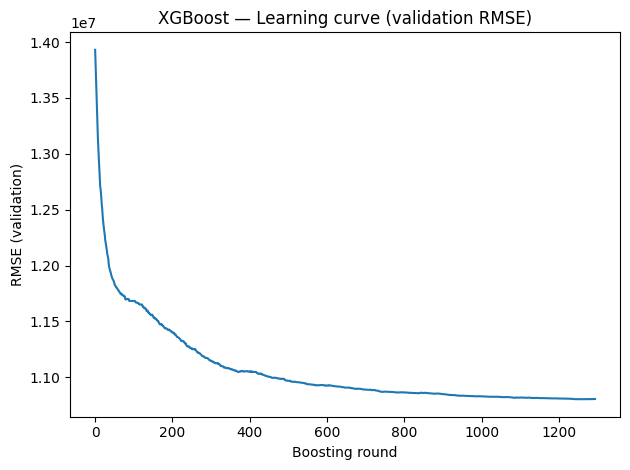

best_iteration: 1243
best_score: 10804429.747569263


In [49]:
results = xgb_es.evals_result()
rmse_val = results["validation_0"]["rmse"]

plt.figure()
plt.plot(rmse_val)
plt.xlabel("Boosting round")
plt.ylabel("RMSE (validation)")
plt.title("XGBoost — Learning curve (validation RMSE)")
plt.tight_layout()
plt.show()

print("best_iteration:", getattr(xgb_es, "best_iteration", None))
print("best_score:", getattr(xgb_es, "best_score", None))


La courbe de RMSE sur le jeu de validation montre une diminution rapide au début de l'entrainement, suivie d'une phase de stabilisation progressive. Cette dynamique indique que le modèle capture efficacement les relations principales dès les premières itérations, puis affine les prédictions sans dégradation des performances sur les données de validation. Le plateau observé après environ 1200 itérations suggère que les arbes supplémentaires apportent peu de gain, ce qui justifie l'utilisation de l'early stopping pour limiter la complexité du modèle. L'absence de remontée du RMSE valide l'absence de surapprentissage sévère et confirme une bonne capacité de généralisation du modèle retenu.

In [50]:
results = xgb_es.evals_result()
rmse_val = results["validation_0"]["rmse"]
best_iter = getattr(xgb_es, "best_iteration", None) 

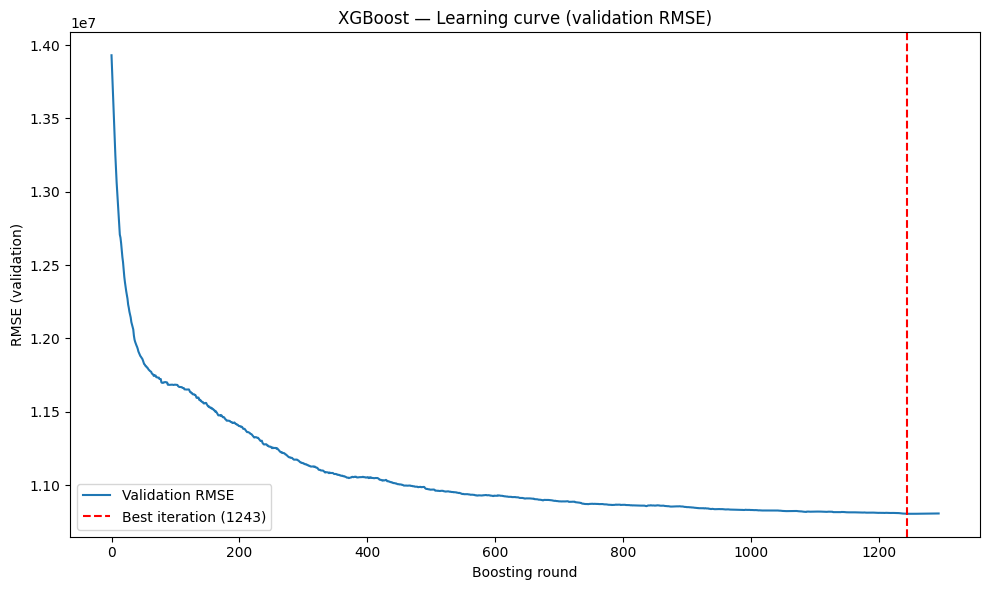

best_iteration: 1243
best_score: 10804429.747569263


In [51]:


plt.figure(figsize=(10, 6))
plt.plot(rmse_val, label="Validation RMSE")


if best_iter is not None:
    plt.axvline(best_iter, color='r', linestyle='--', label=f'Best iteration ({best_iter})')


plt.xlabel("Boosting round")
plt.ylabel("RMSE (validation)")
plt.title("XGBoost — Learning curve (validation RMSE)")
plt.legend() 
plt.tight_layout()
plt.show()


print("best_iteration:", best_iter)
print("best_score:", getattr(xgb_es, "best_score", None))

# ETAPE 10.0 - Validation finale rigoureuse (energie)

Cette section corrige le risque de selection sur le test:
- split train/test une seule fois
- split train/val pour early stopping
- selection sur validation
- evaluation finale unique sur test


In [52]:
import numpy as np
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def safe_stratify(series):
    counts = series.value_counts()
    major = counts.idxmax()
    rare = counts[counts < 2].index
    return series.where(~series.isin(rare), major)


pack = joblib.load('model_data_phase2_v2.joblib')
X_fe = pack['X_fe'].copy()
y_energy = pack['y_energy']
num_cols = pack['num_cols']
cat_cols = pack['cat_cols']

strat_all = safe_stratify(X_fe['BuildingType'])
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_fe,
    y_energy,
    test_size=0.2,
    random_state=42,
    stratify=strat_all,
)

strat_train = safe_stratify(X_train_full['BuildingType'])
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=strat_train,
)

num_used = [c for c in num_cols if c in X_fe.columns]
cat_used = [c for c in cat_cols if c in X_fe.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
            ('scaler', StandardScaler())
        ]), num_used),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_used),
    ]
)

X_train_p = preprocessor.fit_transform(X_train)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)

dtrain = xgb.DMatrix(X_train_p, label=y_train)
dval = xgb.DMatrix(X_val_p, label=y_val)
dtest = xgb.DMatrix(X_test_p)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 5.0,
    'seed': 42,
}

evals_result = {}
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=False,
)

pred_val = bst.predict(dval)
pred_test = bst.predict(dtest)

baseline_val = np.full(len(y_val), y_train.mean())
baseline_test = np.full(len(y_test), y_train.mean())


def score(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return rmse, mae, r2

rmse_val, mae_val, r2_val = score(y_val, pred_val)
rmse_test, mae_test, r2_test = score(y_test, pred_test)
rmse_bv, mae_bv, r2_bv = score(y_val, baseline_val)
rmse_bt, mae_bt, r2_bt = score(y_test, baseline_test)

print('=== Energie - Validation finale rigoureuse ===')
print('Split:', {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)})
print(f'Best iteration: {bst.best_iteration} | Best val RMSE: {min(evals_result["val"]["rmse"]):,.2f}')
print(f'MODEL VAL  -> RMSE: {rmse_val:,.2f} | MAE: {mae_val:,.2f} | R2: {r2_val:.3f}')
print(f'MODEL TEST -> RMSE: {rmse_test:,.2f} | MAE: {mae_test:,.2f} | R2: {r2_test:.3f}')
print(f'BASE  VAL  -> RMSE: {rmse_bv:,.2f} | MAE: {mae_bv:,.2f} | R2: {r2_bv:.3f}')
print(f'BASE  TEST -> RMSE: {rmse_bt:,.2f} | MAE: {mae_bt:,.2f} | R2: {r2_bt:.3f}')


=== Energie - Validation finale rigoureuse ===
Split: {'train': 2142, 'val': 536, 'test': 670}
Best iteration: 1243 | Best val RMSE: 10,804,429.75
MODEL VAL  -> RMSE: 10,805,018.47 | MAE: 1,976,923.35 | R2: 0.415
MODEL TEST -> RMSE: 6,342,842.32 | MAE: 1,955,957.58 | R2: 0.852
BASE  VAL  -> RMSE: 14,143,223.13 | MAE: 5,494,543.34 | R2: -0.002
BASE  TEST -> RMSE: 16,511,086.85 | MAE: 5,948,498.15 | R2: -0.000
